# Introduction

This notebook demonstrates how to perform phase and electrochemical assessments starting from a VASP calculation using Python Materials Genomics (pymatgen) and the Materials Project database (via the Materials API). 

Let's start by importing some modules and classes that we will be using.

In [1]:
%matplotlib inline
import warnings

warnings.simplefilter("ignore")

from pymatgen import MPRester, Composition, Element
from pymatgen.io.vasp import Vasprun
from pymatgen.analysis.phase_diagram import PhaseDiagram, CompoundPhaseDiagram
from pymatgen.analysis.phase_diagram import PDPlotter
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.util.plotting import pretty_plot
import json
import re
import palettable
import matplotlib as mpl

# Preparation

We will first read the results from the *vasprun.xml* output file from our VASP calculations. Only the lowest energy result is used here.

In [2]:
vasprun = Vasprun("vasprun.xml.relax2.gz")
# include structure so proper correction can be applied for oxides and sulfides
entry = vasprun.get_computed_entry(inc_structure=True)

To construct the phase diagram, we need all entries in the Li-P-S-Cl chemical space. We will use the *MPRester* class to obtain these entries from the Materials Project via the Materials API.

In [3]:
rester = MPRester()
mp_entries = rester.get_entries_in_chemsys(["Li", "P", "S", "Cl"])

In addition to all the MP entries, here we also load the computed entries of O/S substituted Li-P-O tenary compounds.

In [4]:
with open("lpo_entries.json") as f:
    lpo_data = json.load(f)
lpo_entries = [ComputedEntry.from_dict(d) for d in lpo_data]

Next, we need to combine all the entries and postprocess them using *MaterialsProjectCompatibility*. This postprocessing step corrects the energies to account for well-known DFT errors, e.g., in the sulfur binding energy.

In [5]:
compatibility = MaterialsProjectCompatibility()
entry = compatibility.process_entry(entry)
entries = compatibility.process_entries([entry] + mp_entries + lpo_entries)

# Phase diagram construction

The phase diagram can then be constructed using the *PhaseDiagram* class, and plotted using the *PDPlotter* class.

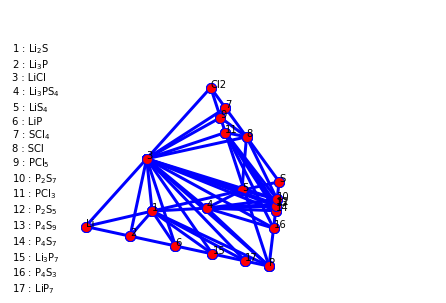

In [6]:
pd = PhaseDiagram(entries)
plotter = PDPlotter(pd)
plotter.show()

We may observe from the above phase diagram that Li6PS5Cl is not a stable phase (red nodes) in the calculated 0K phase diagram.

The pseudo-ternary Li2S-P2S5-LiCl is constructed using the *CompoundPhaseDiagram* class.

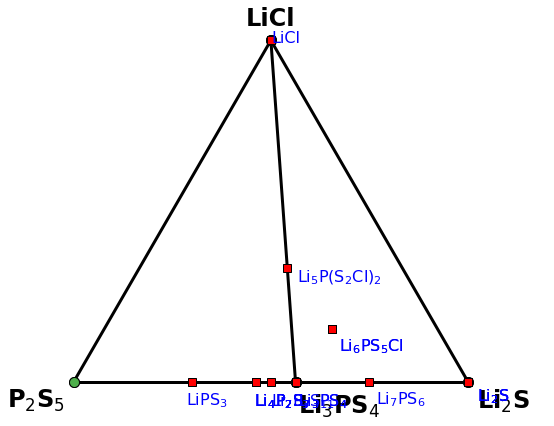

In [7]:
cpd = CompoundPhaseDiagram(entries, 
                           [Composition("P2S5"), Composition("Li2S"), Composition("LiCl")])
cplotter = PDPlotter(cpd, show_unstable=True)
cplotter.show()

# Calculating $E_{\rm hull}$ of Li6PS5Cl

We may evaluate the $E_{\rm hull}$ of Li6PS5Cl using the *PDAnalyzer*.

In [8]:
ehull = pd.get_e_above_hull(entry)
print("The energy above hull of Li6PS5Cl is %.3f eV/atom." % ehull)

The energy above hull of Li6PS5Cl is 0.029 eV/atom.


# Electrochemical Stability

The electrochemical stability can be assessed using a similar phase diagram approach, but using the lithium grand potential instead of the internal energy.

First, we need to identify a reference for lithium chemical potential using the bulk Li energy $\mu_{\rm Li}^0$.

In [9]:
li_entries = [e for e in entries if e.composition.reduced_formula == "Li"]
uli0 = min(li_entries, key=lambda e: e.energy_per_atom).energy_per_atom

The *PDAnalyzer* class provides a quick way to plot the phase diagram at a particular composition (e.g., Li6PS5Cl) as a function of lithium chemical potential called *get_element_profile*.

In [10]:
el_profile = pd.get_element_profile(Element("Li"), entry.composition)
for i, d in enumerate(el_profile):
    voltage = -(d["chempot"] - uli0)
    print("Voltage: %s V" % voltage)
    print(d["reaction"])
    print("")

Voltage: -0.0 V
4 Li6PS5Cl + 32 Li -> 4 Li3P + 4 LiCl + 20 Li2S

Voltage: 0.8697028629166668 V
4 Li6PS5Cl + 24 Li -> 4 LiP + 4 LiCl + 20 Li2S

Voltage: 0.9324093885416653 V
4 Li6PS5Cl + 21.71 Li -> 0.5714 Li3P7 + 4 LiCl + 20 Li2S

Voltage: 1.1619996604166705 V
4 Li6PS5Cl + 20.57 Li -> 0.5714 LiP7 + 4 LiCl + 20 Li2S

Voltage: 1.2717621691666654 V
4 Li6PS5Cl + 20 Li -> 4 LiCl + 20 Li2S + 4 P

Voltage: 1.7076498754523812 V
4 Li6PS5Cl -> 4 Li3PS4 + 4 LiCl + 4 Li2S

Voltage: 2.1291348952380966 V
4 Li6PS5Cl -> 4 Li3PS4 + LiS4 + 4 LiCl + 7 Li

Voltage: 2.368810398840578 V
4 Li6PS5Cl -> 1.5 LiS4 + 4 LiCl + 2 P2S7 + 18.5 Li

Voltage: 2.886446450666666 V
4 Li6PS5Cl -> 0.5 LiS4 + 2 P2S7 + 4 SCl + 23.5 Li

Voltage: 3.7828703591666626 V
4 Li6PS5Cl -> 2 P2S7 + 2 S + 4 SCl + 24 Li



This element profile can be plotted as a Li evolution versus voltage using matplotlib as follows.

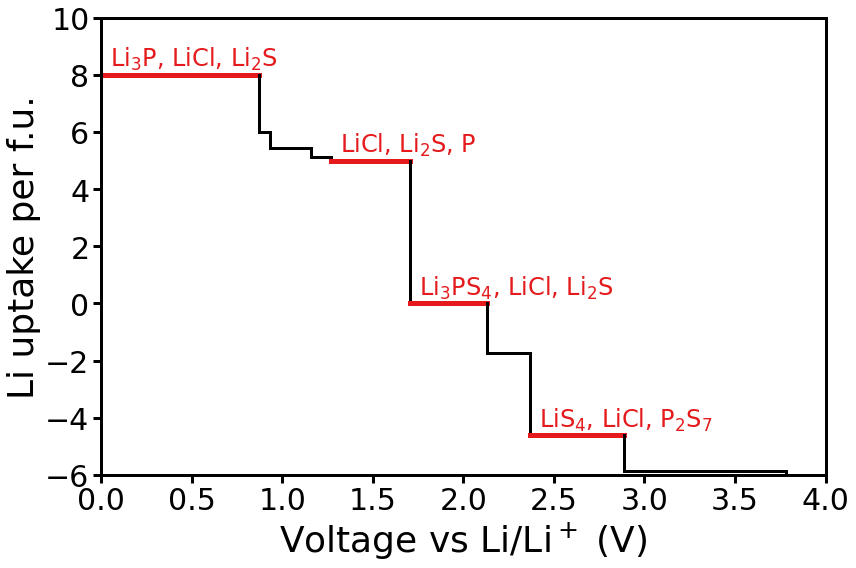

In [11]:
# Some matplotlib settings to improve the look of the plot.
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['lines.markeredgewidth']=4
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['lines.markersize']=15
mpl.rcParams['xtick.major.width']=3
mpl.rcParams['xtick.major.size']=8
mpl.rcParams['xtick.minor.width']=3
mpl.rcParams['xtick.minor.size']=4
mpl.rcParams['ytick.major.width']=3
mpl.rcParams['ytick.major.size']=8
mpl.rcParams['ytick.minor.width']=3
mpl.rcParams['ytick.minor.size']=4


# Plot of Li uptake per formula unit (f.u.) of Li6PS5Cl against voltage vs Li/Li+.

colors = palettable.colorbrewer.qualitative.Set1_9.mpl_colors
plt = pretty_plot(12, 8)

for i, d in enumerate(el_profile):
    v = - (d["chempot"] - uli0)
    if i != 0:
        plt.plot([x2, x2], [y1, d["evolution"] / 4.0], 'k', linewidth=3)
    x1 = v
    y1 = d["evolution"] / 4.0
    if i != len(el_profile) - 1:
        x2 = - (el_profile[i + 1]["chempot"] - uli0)
    else:
        x2 = 5.0
        
    if i in [0, 4, 5, 7]:
        products = [re.sub(r"(\d+)", r"$_{\1}$", p.reduced_formula)                     
                    for p in d["reaction"].products if p.reduced_formula != "Li"]

        plt.annotate(", ".join(products), xy=(v + 0.05, y1 + 0.3), 
                     fontsize=24, color=colors[0])
        
        plt.plot([x1, x2], [y1, y1], color=colors[0], linewidth=5)
    else:
        plt.plot([x1, x2], [y1, y1], 'k', linewidth=3)  

plt.xlim((0, 4.0))
plt.ylim((-6, 10))
plt.xlabel("Voltage vs Li/Li$^+$ (V)")
plt.ylabel("Li uptake per f.u.")
plt.tight_layout()